In [9]:
# a neural network example.  We take an input vector of 10 numbers and
# want the net to return simply the last number.

# Written by Michael Zingale: https://zingale.github.io/ 

import numpy as np
import random
from scipy import optimize
import matplotlib.pyplot as plt
import sys

In [10]:
# we will restrict the numbers in our sample to be drawn from this set
NUM_SET = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [11]:
class ModelData(object):
    """this is the model data for our "last number" training set.  We
    produce input of length N, drawing from the NUM_SET randomly and
    then we set the output to be simply the last element of the input
    vector

    """
    def __init__(self, N=10):
        self.N = N

        # our model input data
        self.x = np.array([random.choice(NUM_SET) for q in range(self.N)])

        # our scaled model output data
        self.y = np.array([self.x[-1]])

    def round_to_allowed(self, out):
        """take the network output and return the number from the allowed
        sequence we are closest to

        """
        return min(NUM_SET, key=lambda q:abs(q - out))

In [12]:
class NeuralNetwork(object):

    def __init__(self, num_training_unique=100, n_epochs=10,
                 use_alpha=True, eps=1.e-8, eta=0.1):
        self.num_training_unique = num_training_unique
        self.n_epochs = n_epochs
        self.eps = eps
        self.eta = eta

        self.train_set = []
        for _ in range(self.num_training_unique):
            self.train_set.append(ModelData())

        # initialize our matrix with Gaussian normal random numbers
        # we get the size from the length of the input and output
        model = self.train_set[0]
        self.m = len(model.y)
        self.n = len(model.x)

        self.A = np.random.normal(0.0, 1.0/np.sqrt(self.n), (self.m, self.n))

        if use_alpha:
            self.compute_alpha()
        else:
            self.alpha = 1.0

    def compute_alpha(self):
        """figure out a good value for alpha"""
        max_x = -1.0
        for model in self.train_set:
            max_x = max(max_x, np.abs(model.x).max())

        self.alpha = 10.0/(self.n * max_x)

    def g(self, p):
        """our sigmoid function"""
        return 1.0/(1.0 + np.exp(-self.alpha*p))

    def f_minimize(self, A_elements, x, y):
        """ This is the function we want to minimize for training"""
        A = A_elements.reshape((self.m, self.n))
        z = self.g(A @ x)

        return (z - y) @ (z - y)

    def train(self, use_scipy=True):
        """Do the minimization for the training using SciPy's minimization"""

        # train
        for _ in range(self.n_epochs*len(self.train_set)):
            model = random.choice(self.train_set)

            if use_scipy:
                res = optimize.minimize(self.f_minimize, self.A.flatten(),
                                        args=(model.x, model.y), tol=self.eps)

                if not res.success:
                    sys.exit("training optimization failed")

                self.A[:,:] = res.x.reshape((len(model.y), len(model.x)))

            else:
                # gradient descent -- just a single improvement.  eta
                # here is our learning rate

                # make these column vectors
                x = model.x.reshape(self.n, 1)
                y = model.y.reshape(self.m, 1)

                b = self.A @ x
                z = self.g(b)

                self.A[:,:] += -self.eta * 2*self.alpha*(z - y)*z*(1 - z) @ x.T


    def predict(self, model):
        """ predict the outcome using our trained matrix A """
        z = self.g(self.A @ model.x)
        return model.round_to_allowed(z)

In [13]:
def main(use_scipy=True, use_alpha=True, eta=0.1):

    if use_scipy:
        plt_suffix = "_scipy.png"
    else:
        plt_suffix = "_grad_descent.png"

    # length of our input vector
    nn = NeuralNetwork(num_training_unique=100, n_epochs=100, use_alpha=use_alpha, eta=eta)

    # train
    nn.train(use_scipy=use_scipy)

    print("trained matrix: ")
    print(nn.A)
    print(" ")

    # try it out -- first on our original training set data
    err = []
    for model in nn.train_set:
        y_nn = nn.predict(model)
        err.append(float(y_nn - model.x[-1]))

    plt.clf()
    xerr = np.arange(0,len(err),1)
    markerline, stemlines, baseline = plt.stem(xerr, err, ":")#, color="C0")
    plt.setp(stemlines, "color", "C0")
    plt.savefig("trained_data" + plt_suffix, dpi=150)

    # now try it out on 100 different new random sequences
    err = []
    npts = 100
    n_right = 0
    for k in range(npts):
        model = ModelData()
        y_nn = nn.predict(model)
        e = float(y_nn - model.x[-1])
        if e == 0:
            n_right += 1
        err.append(e)

    plt.clf()
    xerr = np.arange(0,len(err),1)
    markerline, stemlines, baseline = plt.stem(xerr,err, ":") #color="C0")
    plt.setp(stemlines, "color", "C0")
    plt.savefig("random_data" + plt_suffix, dpi=150)

    return n_right / npts

trained matrix: 
[[-0.61295151 -0.47345718 -0.31531811 -0.37760356 -0.39940494 -0.67518272
  -0.67708669 -0.45363053 -0.5484276   4.6343851 ]]
 
frac: 0.49


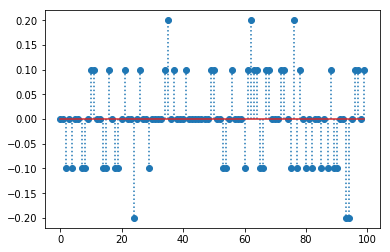

In [14]:
if __name__ == "__main__":
    #f = main(use_alpha=False)
    #print("frac: {}".format(f))

    f = main(use_scipy=False, use_alpha=False, eta=0.2)
    print("frac: {}".format(f))
